## Breast Cancer Diagnosis

This is a simple statistical approach to breast cancer diagnosis

In [301]:
#import sys
#!{sys.executable} -m pip install statsmodels

In [469]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn.linear_model
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from patsy import dmatrices

## 1. Data Formatting

In [453]:
# load file into pandas
data_txt = "breast-cancer-wisconsin.txt"
feats = ['ID number', 'clump thickness', 
         'uniformity of cell shape', 'marginal adhesion',
         'single epithelial cell size', 'bare nuclei',
         'bland chromatin', 'normal nucleoli', 'mitosis',
         'class']
df = pd.read_csv(data_txt, names=feats)

# visualize data format
df.head()
df.shape

(699, 10)

In [454]:
# write function that replaces unknown parameters with NaN
df = df.replace('?', np.NaN);

# skip rows with missing data
tempDf = df.dropna()
df = tempDf

In [455]:
# convert variables to appropriate types
df["bare nuclei"] = (df["bare nuclei"]).astype(int)
print(df.dtypes)

ID number                      int64
clump thickness                int64
uniformity of cell shape       int64
marginal adhesion              int64
single epithelial cell size    int64
bare nuclei                    int64
bland chromatin                int64
normal nucleoli                int64
mitosis                        int64
class                          int64
dtype: object


# 2. Clump Thickness Comparison

In [456]:
# find indices of patients with malignant tumors
malig_data = (df[:]==4)['class'] # returns 2 vectors, first with patient ID, 2nd boolean for malignant tumor

# split data indices into malignant and nonmalignant groups
malignant_index = np.where(malig_data == 1)
nonmalignant_index = np.where(malig_data == 0)

# create np arrays for intended variables
class_array = np.array(df['class'])
clump_array = np.array(df['clump thickness'])

# create clump thickness vectors for each population
mal_clumps = clump_array[malignant_index]
nonmal_clumps = clump_array[nonmalignant_index]

Text(0.5, 1.0, 'Clump Thickness')

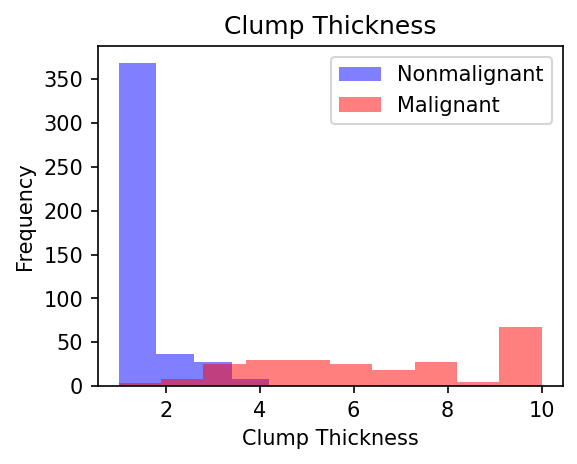

In [457]:
# visualize clump data as histogram 
fig1 = plt.figure(num=1, figsize=(4, 3), dpi=150)

plt.hist(nonmal_clumps, lw=3, fc=(0, 0, 1, 0.5))
plt.hist(mal_clumps, lw=3, fc=(1, 0, 0, 0.5))

labels= ['Nonmalignant','Malignant']
plt.legend(labels)
plt.xlabel('Clump Thickness')
plt.ylabel('Frequency')
plt.title('Clump Thickness')

Things to note about the above histogram: The nonmalignant clump thickness has much lower numerical values on average, as well as a smaller variance. The malignant clump thickness meanwhile have slightly higher numerical values on avearage, and have a much larger variance. It's clear just from the histogram that the 2 distribuations are not normally distributed. This rules out some common tests like the t-test for determining statistichal difference in mean between 2 distribuations, but let's double check by creating some qq plots.

Text(0, 0.5, 'ylabel')

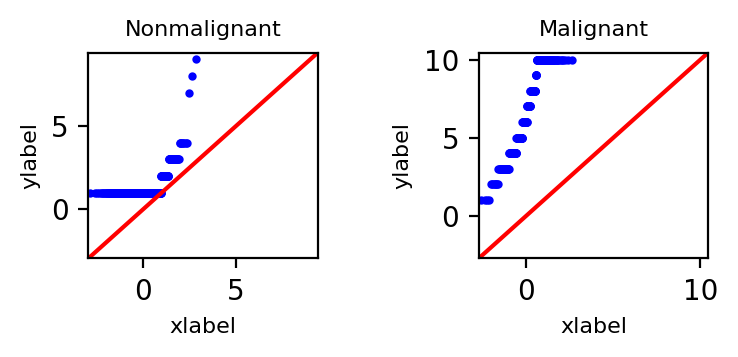

In [458]:
# plot qq plot: purpose is to determine if 2 populations come from populations with common distributions
fig2 = plt.figure(num=2, figsize=(4, 3), dpi=200)
fig2.subplots_adjust(wspace=0.7)

ax = fig2.add_subplot(2, 2, 1)
sm.qqplot(nonmal_clumps, line='45',ax=ax, markersize=2)
plt.title('Nonmalignant', fontsize=8)
plt.xlabel('xlabel', fontsize=8)
plt.ylabel('ylabel', fontsize=8)

ax = fig2.add_subplot(2, 2, 2)
sm.qqplot(mal_clumps, line='45',ax=ax, markersize=2)
plt.title('Malignant', fontsize=8)
plt.xlabel('xlabel', fontsize=8)
plt.ylabel('ylabel', fontsize=8)

As predicted by the first histogram, the data is not normally distributed, so a 2 sample t-test can't be used to decide if clump thickness is significantly different between malignant and nonmalignant populations. 

Mann Whitney U tests can be used to determine if 2 non-normal distributions are similar. Here are the assumptions:

    1. One continuous independent variable: clump size is on a continuous scale, check
    2. Two categorical independent variables: malignant vs. non malignant are clearly 2 separate categories, check
    3. Independence of observation: no subject would be in both the malignant and malignant groups, so we can 
       assume this ones okay.
    4. Similar shaped distributions: from the histogram above, it looks like the distributions do not have similar
       shapes. Therefore, we should keep in mind that the Mann Whitney U test will help determine if the
       distributions are different (rather than their means being different specifically).
       
       
If we get a p-value of less than 0.05, this should mean the 2 distributions are statistichally different with 95% confidence. 

In [459]:
sp.stats.mannwhitneyu(mal_clumps,nonmal_clumps)

MannwhitneyuResult(statistic=2565.5, pvalue=4.404555983232996e-112)

That's a tiny p-value! Looks like clump thickness distributions for malignant vs. non malignant populations are in fact significantly different. Let's look at all features (uniformity of cell shape, marginal adhesion etc.) and determine the following for each feature:

    1. Are the malignant and non malignant populations normally distributed?
    2. Do the malignant and non malignant poupulations have similar shapes (variances)?
    3. Are the malignant and non malignant populations significantly different (use t-test vs. Mann Whitney U test  
       depending on the above answers)?

## 3. Feature Normality and Distribution Differences 

In [460]:
norm_mal = [False for i in range(len(feats)-2)] 
norm_nonmal = [False for i in range(len(feats)-2)] 
p_val = [False for i in range(len(feats)-2)]
int_list = [1,2,3,4,6,7,8,9] # only include integer variables in this analysis

for x in range(len(int_list)): 
    # create np array for intended variable
    temp_array = []
    temp_array = np.array(df[feats[int_list[x]]])

    # create single feature vectors for each population
    mal_feat = temp_array[malignant_index]
    nonmal_feat = temp_array[nonmalignant_index]

    # any value above 0.05 on the Shapiro Wilk test signals normality of the data
    p_mal = (sp.stats.shapiro(mal_feat))[1] # this scipy test outputs the statistic value and p value
    p_nonmal = (sp.stats.shapiro(nonmal_feat))[1]
    norm_mal[x] = (p_mal>0.05)
    norm_nonmal[x] = (p_nonmal>0.5)    

    if norm_mal[x] == True:
        # t-test
        p_val[x] = sp.stats.ttest_ind(mal_clumps,nonmal_clumps)[1] < 0.05
    else:
        # mann whitney u test 
        p_val[x] = (sp.stats.mannwhitneyu(mal_clumps,nonmal_clumps))[1] < 0.05
        
print('Are these features good indications of malignant vs. non malignant tissue?')
print(p_val)
print()
print('Looks like yes for everything...!')

Are these features good indications of malignant vs. non malignant tissue?
[True, True, True, True, True, True, True, True]

Looks like yes for everything...!


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


## 4. PCA

Since there are so many features that seem to be good indicators of malignancy vs. non malignancy, let's use PCA (principal component analysis) to boil down to a couple of new features that are basically a combination of all the original features. This would just make computations easier as the dataset grows.

The simplest place to start is a 2D PCA.

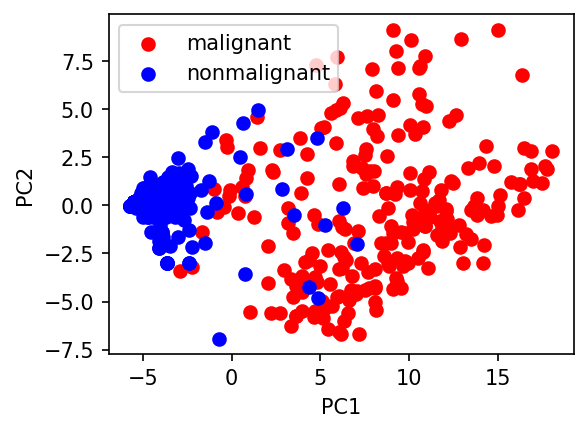

In [461]:
sklearn_pca = PCA(n_components=2)

# don't worry about using IDs or class labels for principal component generation
y_sklearn = sklearn_pca.fit_transform(df.iloc[:, 1:-1]) 
PC1 = y_sklearn[:,0]
PC2 = y_sklearn[:,1]

fig3 = plt.figure(num=1, figsize=(4, 3), dpi=150)

plt.scatter(PC1[malignant_index], PC2[malignant_index], c='r', label='malignant')
plt.scatter(PC1[nonmalignant_index], PC2[nonmalignant_index], c='b', label='nonmalignant')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper left')

Visually, it looks like the malignant and nonmalignant samples are pretty distinguishable with our new principal component variables. Success. Next, let's see if we can quantitatively predict malignancy given this new reduced dataset. We'll use k means clustering, one of the most popular was to categorize data in an unsupervised manner. 

In [464]:
# use k means algorithm to predict group for each point
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(df.iloc[:,1:-1])

# use for loop to change kmeans.lables_ from 0 or 1 to 2 or 4 (so it matches the initial class list)
for i,value in enumerate(kmeans.labels_):
    if value==0: # non malignant
        kmeans.labels_[i] = 2
    if value==1: # malignant
        kmeans.labels_[i] = 4
        
accuracy = sum(kmeans.labels_==class_array)/len(kmeans.labels_)
print(accuracy)

0.9560761346998536


Not too bad! Let's try a supervised machine learning algorithm -- logistic regression -- next.

In [491]:
# shuffle data to prepare for 10 fold cross validation
from sklearn.utils import shuffle
df_shuffled = shuffle(df)
cross_val = 10
x = math.floor(len(df_shuffled)/cross_val) # size of each fold for 10x cross validation

# folds = range(10)

# # train with 9 sets, test on 1 set
# for i in range(cross_val):
#     train_ind = [i for i, x in enumerate(folds) if !x]
#     training = df_shuffled.iloc[train_ind,1:]
#     test = df_shuffled.iloc[i,]

    
training = df_shuffled.iloc[0:(9*x),1:]
test = df_shuffled.iloc[(9*x):,1:]

model = sklearn.linear_model.LogisticRegression()
model.fit(training.iloc[:,:-1], training.iloc[:,-1]) #(data, labels)
prediction = model.predict(test.iloc[:,:-1])

# check if prediction matches actual labels
acc = sum(prediction==test.iloc[:,-1])/len(prediction)
print(acc)

0.9436619718309859
